In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model

In [2]:
# Get training property info

filename = 'Data/train_2016.csv'
trainid_df = pd.read_csv(filename)

# Get property info

filename = 'Data/properties_2016.csv'
properties_df = pd.read_csv(filename)

C:\Users\Matthew\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Put respective properties_df info into train_df.

properties_df.set_index('parcelid', inplace = True)
trainid_df.set_index('parcelid', inplace = True)

train_df = trainid_df.join(properties_df)

In [4]:
# Try diffusing when propertylandusetypeid is 261.0 and when it is not.

vals_df = train_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]
vals_df = vals_df.dropna()

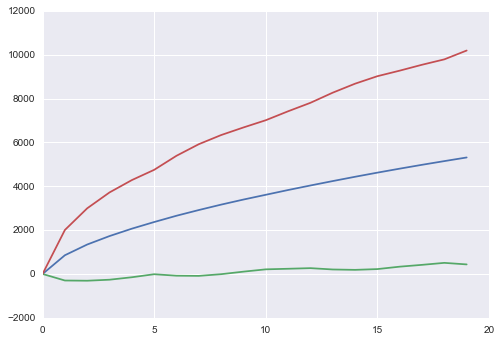

In [5]:
# Get an idea of how large the distances are for up to 20 neighbors
nbrs = NearestNeighbors(20)
nbrs.fit(vals_df[['latitude', 'longitude']])
points = vals_df[['latitude', 'longitude']]
distances, indices = nbrs.kneighbors(points)
meandist = np.mean(distances, axis = 0)
stddist = np.std(distances, axis = 0)

plt.plot(meandist)
plt.plot(meandist - stddist)
plt.plot(meandist + stddist)
plt.show()

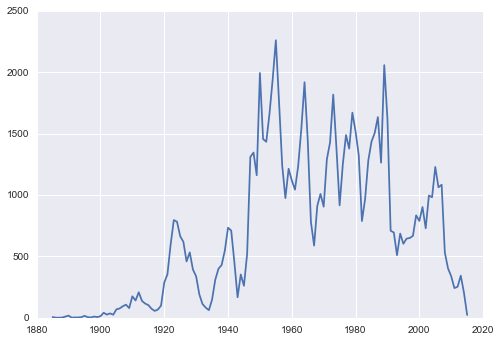

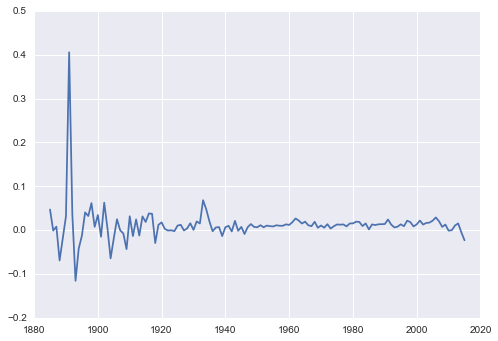

In [6]:
# Let's investigate diffusing the year built.

vars_df = train_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]

grouped_df = vars_df.groupby('yearbuilt').count()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

grouped_df = vars_df.groupby('yearbuilt').mean()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

In [7]:
# Find initial diffusion data, use average depending on distance.

vals_df = train_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]
vals_df = vals_df.dropna()
diffinit = vals_df['yearbuilt'].values.T
        
errors = []

ks = range(1, 80, 4)
nbrs = NearestNeighbors()
nbrs.fit(vals_df[['latitude', 'longitude']])

diffusions = np.zeros(diffinit.shape)
coords = vals_df[['latitude', 'longitude']].values

epsilon = 10**3
for k in ks:
    
    nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)

    nbrdiffusions = diffinit[nbrindex]
    nbrdistance += epsilon
    nbrdistance = 1.0 / nbrdistance
    meandiffusions = nbrdistance * nbrdiffusions
    meandiffusions = np.sum(meandiffusions, axis = 1)
    meandiffusions /= np.sum(nbrdistance, axis = 1)
    newdiffusions = np.stack((meandiffusions, diffinit))
    diffusions = np.amax(newdiffusions, axis = 0)
    
    linregr = linear_model.LinearRegression()
    x_train = np.stack((diffusions, diffinit)).T
    #x_train = x_train.reshape(-1,1)
    y_train = vals_df['logerror'].values
    y_train = y_train.reshape(-1,1)
    
    linregr.fit(x_train, y_train)
    y_predict = linregr.predict(x_train)
    newerrors = y_train - y_predict
    errors.append(newerrors)

(20, 89519, 1)


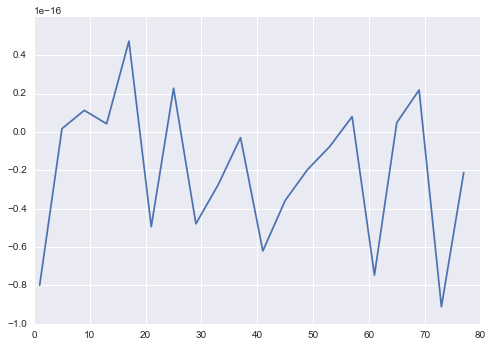

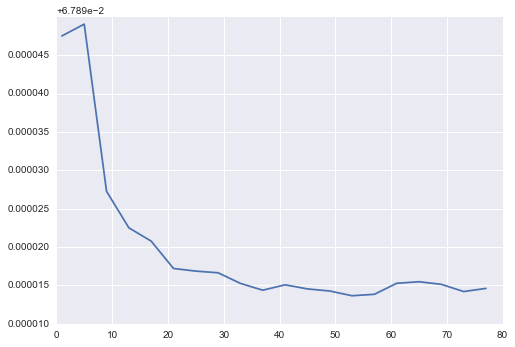

In [8]:
errors = np.array(errors)
print(errors.shape)
abserrors = np.abs(errors)

plt.plot(ks, np.mean(errors, axis = 1))
plt.show()

plt.plot(ks, np.mean(abserrors, axis = 1))
plt.show()

In [9]:
# Try using 35 neighbors.

k = 25
nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)

nbrdiffusions = diffinit[nbrindex]
nbrdistance += epsilon
nbrdistance = 1.0 / nbrdistance
meandiffusions = nbrdistance * nbrdiffusions
meandiffusions = np.sum(meandiffusions, axis = 1)
meandiffusions /= np.sum(nbrdistance, axis = 1)
newdiffusions = np.stack((meandiffusions, diffinit))
diffusions = np.amax(newdiffusions, axis = 0)

vals_df['diffusions'] = diffusions

In [10]:
# Bin diffusion values.

nbins = 200
minval = np.amin(diffusions)
maxval = np.amax(diffusions)
bindiffusions = (diffusions - minval) / (maxval - minval) * nbins
bindiffusions = bindiffusions.astype(int)
bindiffusions = bindiffusions * (maxval - minval) / nbins + minval

vals_df['bindiffusions'] = bindiffusions

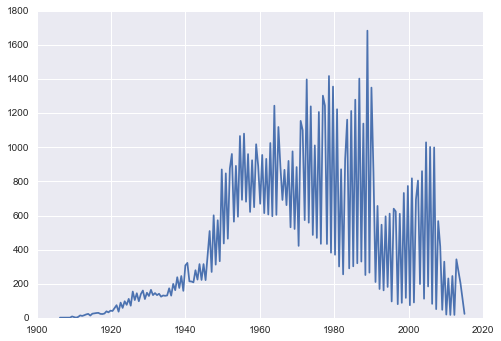

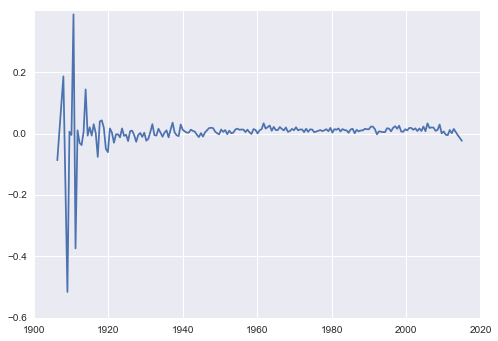

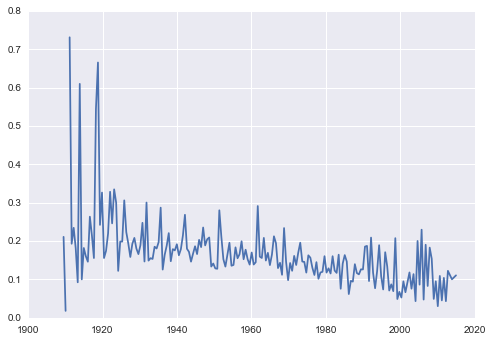

In [11]:
# Group the data by bins for diffusion values.

grouped_df = vals_df.groupby('bindiffusions').count()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

grouped_df = vals_df.groupby('bindiffusions').mean()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

grouped_df = vals_df.groupby('bindiffusions').std()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

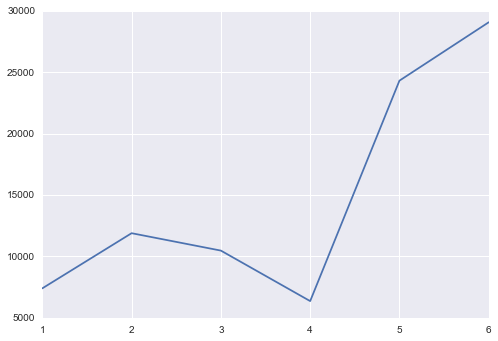

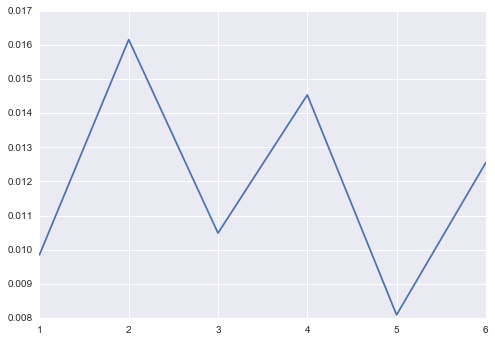

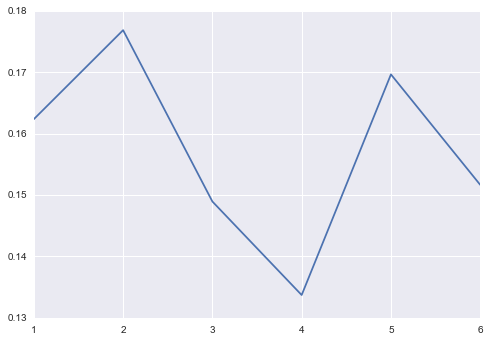

In [12]:
# Investigate these peaks that have formed in the year built distribution.

diffusion_cat = diffusions.copy()
for i in range(len(diffusion_cat)):
    val = diffusion_cat[i]
    if 1955 < val and val < 1960:
        diffusion_cat[i] = 1
    elif 1960 < val and val < 1968:
        diffusion_cat[i] = 2
    elif 1970 < val and val < 1977:
        diffusion_cat[i] = 3
    elif 1987 < val and val < 1992:
        diffusion_cat[i] = 4
    elif 1930 < val and val < 1980:
        diffusion_cat[i] = 5
    else:
        diffusion_cat[i] = 6
        
vals_df['diffusion_cat'] = diffusion_cat.T

grouped_df = vals_df.groupby('diffusion_cat').count()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

grouped_df = vals_df.groupby('diffusion_cat').mean()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

grouped_df = vals_df.groupby('diffusion_cat').std()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

In [13]:
# Now try just simply using the mean values of diffusion category.
grouped_df = vals_df.groupby('diffusion_cat').mean()
catpredict = grouped_df['logerror'].values

newpredict = []
for i in range(len(diffusion_cat)):
    newprediction = catpredict[int(diffusion_cat[i] - 1)]
    newpredict.append(newprediction)

newpredict = np.array(newpredict)
errorpredict = newpredict - vals_df['logerror'].values

print('mean error prediction = ', np.mean(errorpredict))
newesterror = np.mean(np.abs(errorpredict))
print('abs error prediction = ', newesterror)
origerror = np.mean(np.abs(vals_df['logerror'].values))
print('Original abs error = ', origerror)
print('Difference = ', newesterror - origerror)

(newesterror - origerror) / origerror

mean error prediction =  -2.65900888615e-17
abs error prediction =  0.0679258142366
Original abs error =  0.0678984975257
Difference =  2.7316710944e-05


0.00040231686914177282

In [14]:
# Now try just using mean value for category with small standard deviation.
grouped_df = vals_df.groupby('diffusion_cat').mean()
catpredict = grouped_df['logerror'].values

newpredict = []
for i in range(len(diffusion_cat)):
    if diffusion_cat[i] == 4 or diffusion_cat[i] == 3 or diffusion_cat[i] == 6 or diffusion_cat[i] == 1:
        newprediction = catpredict[int(diffusion_cat[i] - 1)]
    else:
        newprediction = 0.0
    newpredict.append(newprediction)
    
newpredict = np.array(newpredict)
errorpredict = newpredict - vals_df['logerror'].values

print('mean error prediction = ', np.mean(errorpredict))
newesterror = np.mean(np.abs(errorpredict))
print('abs error prediction = ', newesterror)
origerror = np.mean(np.abs(vals_df['logerror'].values))
print('Original abs error = ', origerror)
print('Difference = ', newesterror - origerror)

(newesterror - origerror) / origerror

mean error prediction =  -0.00434300986383
abs error prediction =  0.0678220130882
Original abs error =  0.0678984975257
Difference =  -7.64844374459e-05


-0.0011264525760227408

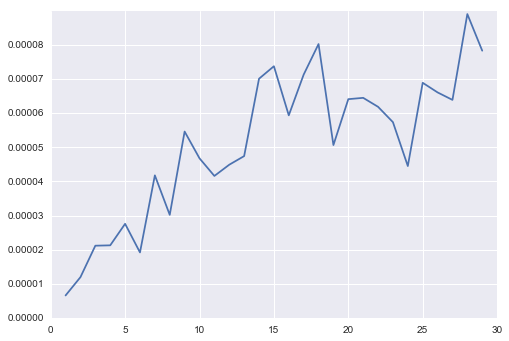

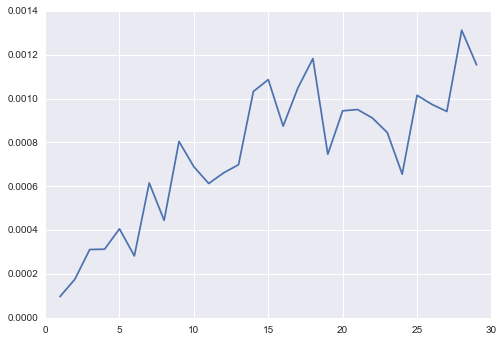

In [49]:
# Do piecewise constant regression for different numbers of piecewise linear intervals on diffusions variable.

maxsearch = 30

errorChangeList = []
relativeChangeList = []
nIntervalsList = range(1, maxsearch, 1)

for nintervals in nIntervalsList:
    linregr = linear_model.LinearRegression(fit_intercept = False)

    nrows = len(vals_df.diffusions.values)
    
    x_train = np.full((nrows, 1), 1.0)
    minval = np.amin(vals_df.diffusions.values)
    maxval = np.amax(vals_df.diffusions.values)
    dint = (maxval - minval) / nintervals

    for i in range(1, nintervals):
        piecewise = np.zeros(nrows)
        indices = (vals_df.diffusions.values - minval)> (i * dint)
        piecewise[indices] = 1.0
        piecewise = piecewise.reshape(-1,1)
        x_train = np.hstack((x_train, piecewise))

    y_train = vals_df.logerror.values
    y_train = y_train.reshape(-1,1)

    linregr.fit(x_train, y_train)
    y_predict = linregr.predict(x_train)

    errorpredict = y_predict - y_train

    newesterror = np.mean(np.abs(errorpredict))
    
    origerror = np.mean(np.abs(vals_df['logerror'].values))
    errorChangeList.append(newesterror - origerror)

    relativeChangeList.append((newesterror - origerror) / origerror)
    
plt.plot(nIntervalsList, errorChangeList)
plt.show()

plt.plot(nIntervalsList, relativeChangeList)
plt.show()

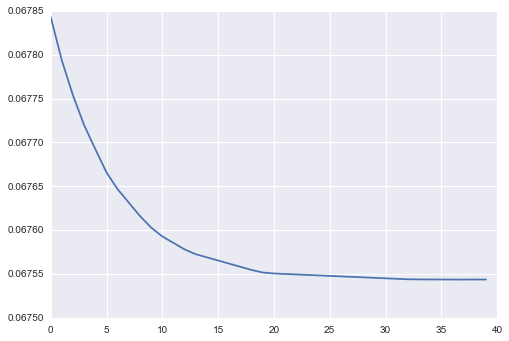

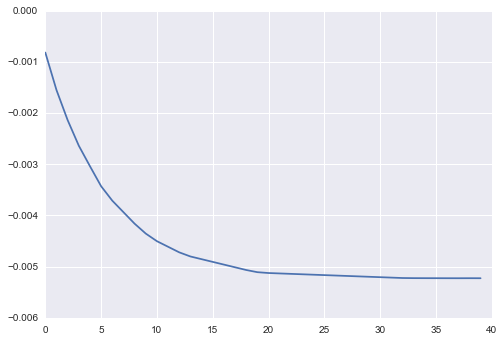

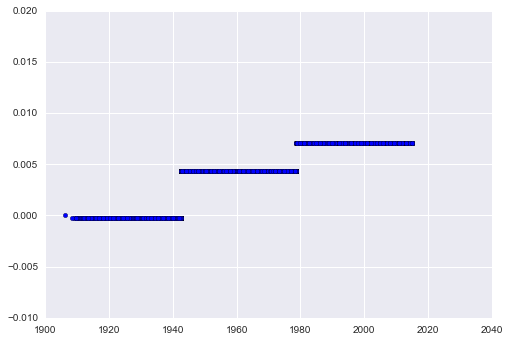

-0.005226534340990607

In [93]:
# Try doing gradient descent for piecewise constant.

niterations = 40
nintervals = 3
rate = 0.0000001
constants = np.zeros(nintervals)

minval = np.amin(vals_df.diffusions.values)
maxval = np.amax(vals_df.diffusions.values)
dint = (maxval - minval) / nintervals
x_train = vals_df.diffusions.values
y_train = vals_df.logerror.values
y_predict = np.zeros(len(y_train))

origerror = np.mean(np.abs(y_train))
absChange = []
absRelativeChange = []

for i in range(niterations):
    
    for interval in range(nintervals):
        diffindices = (interval * dint + minval) < x_train
        diffindices = diffindices & (x_train <= (interval+1) * (dint) + minval)
        yvals = y_train[diffindices]
        indices = yvals > constants[interval]
        grad = -len(yvals[indices])
        indices = yvals < constants[interval]
        grad += len(yvals[indices])
        constants[interval] -= grad * rate
        
        y_predict[diffindices] = constants[interval]
        
    y_errors = np.abs(y_train - y_predict)
    absChange.append(np.mean(y_errors))
    
    absRelativeChange.append(np.mean(y_errors - origerror) / origerror)
    
plt.plot(absChange)
plt.show()

plt.plot(absRelativeChange)
plt.show()

plt.scatter(x_train, y_predict)
plt.show()

absRelativeChange = np.array(absRelativeChange)
np.amin(absRelativeChange)

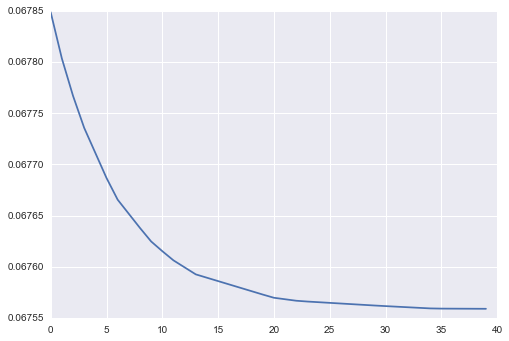

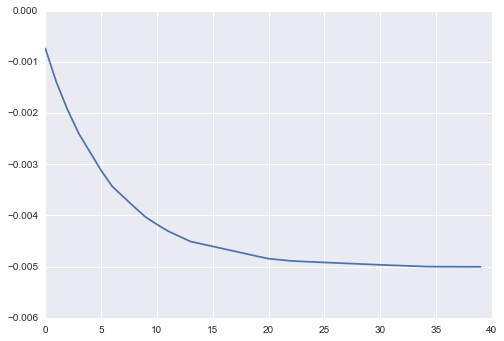

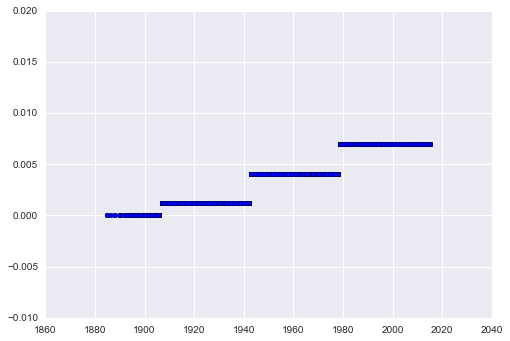

-0.0050029541942446703

In [94]:
# Try doing gradient descent for piecewise constant but for just yearbuilt.

niterations = 40
nintervals = 3
rate = 0.0000001
constants = np.zeros(nintervals)

minval = np.amin(vals_df.diffusions.values)
maxval = np.amax(vals_df.diffusions.values)
dint = (maxval - minval) / nintervals
x_train = vals_df.yearbuilt.values
y_train = vals_df.logerror.values
y_predict = np.zeros(len(y_train))

origerror = np.mean(np.abs(y_train))
absChange = []
absRelativeChange = []

for i in range(niterations):
    
    for interval in range(nintervals):
        diffindices = (interval * dint + minval) < x_train
        diffindices = diffindices & (x_train <= (interval+1) * (dint) + minval)
        yvals = y_train[diffindices]
        indices = yvals > constants[interval]
        grad = -len(yvals[indices])
        indices = yvals < constants[interval]
        grad += len(yvals[indices])
        constants[interval] -= grad * rate
        
        y_predict[diffindices] = constants[interval]
        
    y_errors = np.abs(y_train - y_predict)
    absChange.append(np.mean(y_errors))
    
    absRelativeChange.append(np.mean(y_errors - origerror) / origerror)
    
plt.plot(absChange)
plt.show()

plt.plot(absRelativeChange)
plt.show()

plt.scatter(x_train, y_predict)
plt.show()

absRelativeChange = np.array(absRelativeChange)
np.amin(absRelativeChange)

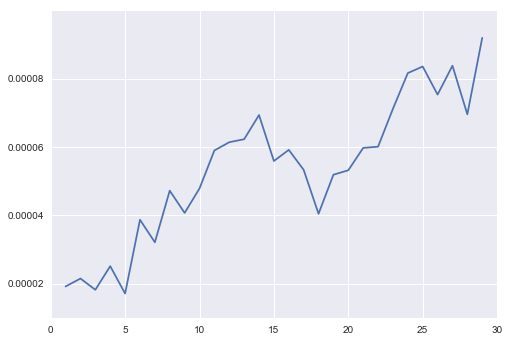

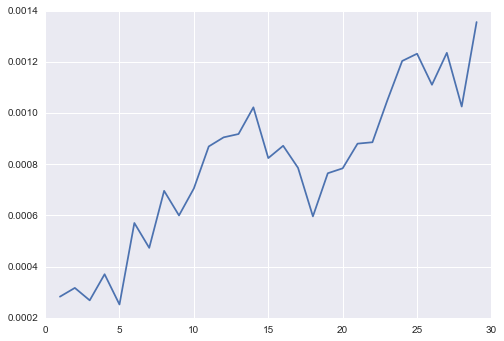

In [48]:
# Do piecewise linear regression for different numbers of piecewise linear intervals on diffusions variable.

maxsearch = 30

errorChangeList = []
relativeChangeList = []
nIntervalsList = range(1, maxsearch, 1)

for nintervals in nIntervalsList:
    linregr = linear_model.LinearRegression()

    x_train = vals_df.diffusions.values.reshape(-1,1)
    minval = np.amin(x_train)
    maxval = np.amax(x_train)
    dint = (maxval - minval) / nintervals

    zeroarray = np.zeros(len(vals_df.diffusions.values)).reshape(-1,1)
    for i in range(1, nintervals):
        # If you forget to put -minval here then you somehow get better results.
        piecewise = (vals_df.diffusions.values - minval - i * dint)
        piecewise = piecewise.reshape(-1,1)
        piecewise = np.hstack((piecewise, zeroarray))
        piecewise = np.amax(piecewise, axis = 1).reshape(-1,1)
        x_train = np.hstack((x_train, piecewise))

    y_train = vals_df.logerror.values
    y_train = y_train.reshape(-1,1)

    linregr.fit(x_train, y_train)
    y_predict = linregr.predict(x_train)

    errorpredict = y_predict - y_train

    newesterror = np.mean(np.abs(errorpredict))
    
    origerror = np.mean(np.abs(vals_df['logerror'].values))
    errorChangeList.append(newesterror - origerror)

    relativeChangeList.append((newesterror - origerror) / origerror)
    
plt.plot(nIntervalsList, errorChangeList)
plt.show()

plt.plot(nIntervalsList, relativeChangeList)
plt.show()

In [28]:
# Given success of only adjusting on certain categories, should try either piecewise linear or a logistic regresssion
# on the diffusion variable.

nintervals = 12

linregr = linear_model.LinearRegression()

x_train = vals_df.diffusions.values.reshape(-1,1)
minval = np.amin(x_train)
maxval = np.amax(x_train)
dint = (maxval - minval) / nintervals

zeroarray = np.zeros(len(vals_df.diffusions.values)).reshape(-1,1)
for i in range(1, nintervals):
    piecewise = (vals_df.diffusions.values - i * dint)
    piecewise = piecewise.reshape(-1,1)
    piecewise = np.hstack((piecewise, zeroarray))
    piecewise = np.amax(piecewise, axis = 1).reshape(-1,1)
    x_train = np.hstack((x_train, piecewise))
    
print(x_train.shape)

y_train = vals_df.logerror.values
y_train = y_train.reshape(-1,1)

linregr.fit(x_train, y_train)
y_predict = linregr.predict(x_train)

errorpredict = y_predict - y_train

print('mean error prediction = ', np.mean(errorpredict))
newesterror = np.mean(np.abs(errorpredict))
print('abs error prediction = ', newesterror)
origerror = np.mean(np.abs(vals_df['logerror'].values))
print('Original abs error = ', origerror)
print('Difference = ', newesterror - origerror)

(newesterror - origerror) / origerror

(89519, 12)
mean error prediction =  -0.00707314288726
abs error prediction =  0.0676461652345
Original abs error =  0.0678984975257
Difference =  -0.00025233229119


-0.0037163162718617613

In [17]:
# Try linear fit on each category.

linregr = linear_model.LinearRegression()
catregrpredict = vals_df['logerror'].values.copy()

for catvalue in range(1,7,1):
    
    indices = diffusion_cat == catvalue
    x_train = vals_df[['yearbuilt', 'diffusions']].values[indices]
    y_train = vals_df['logerror'].values[indices]
    y_train = y_train.reshape(-1,1)
    
    linregr.fit(x_train, y_train)
    y_predict = linregr.predict(x_train)
    catregrpredict[indices] = y_predict.flat
    
predicterror = catregrpredict - vals_df['logerror'].values
meanerror = np.mean(predicterror)
print('mean error prediction = ', meanerror)
meanabserror = np.mean(np.abs(predicterror))
print('mean abs error predictions = ', meanabserror)

(meanabserror - origerror) / origerror

mean error prediction =  -8.68344991478e-17
mean abs error predictions =  0.0679470910077


0.00071567831172403035

In [18]:
# Try linear fit on simply year built and diffusions

linregr = linear_model.LinearRegression()

x_train = vals_df[['yearbuilt', 'diffusions']].values
y_train = vals_df['logerror'].values
y_train = y_train.reshape(-1,1)
    
linregr.fit(x_train, y_train)
y_predict = linregr.predict(x_train)
    
predicterror = y_predict.flat - vals_df['logerror'].values
meanerror = np.mean(predicterror)
print('mean error prediction = ', meanerror)
meanabserror = np.mean(np.abs(predicterror))
print('mean abs error predictions = ', meanabserror)

(meanabserror - origerror) / origerror

mean error prediction =  8.57232715536e-18
mean abs error predictions =  0.0679068680334


0.00012327972031735737

In [19]:
# Try linear fit on simply year built

linregr = linear_model.LinearRegression()

x_train = vals_df[['yearbuilt']].values
y_train = vals_df['logerror'].values
y_train = y_train.reshape(-1,1)
    
linregr.fit(x_train, y_train)
y_predict = linregr.predict(x_train)
    
predicterror = y_predict.flat - vals_df['logerror'].values
meanerror = np.mean(predicterror)
print('mean error prediction = ', meanerror)
meanabserror = np.mean(np.abs(predicterror))
print('mean abs error predictions = ', meanabserror)

(meanabserror - origerror) / origerror

mean error prediction =  6.5879921657e-18
mean abs error predictions =  0.0679382015351


0.00058475534682469858